<div class="alert alert-success">
<h3> Will be transated...</h3>

</div>

## Определение перспективного тарифа для телеком компании
---
Планируется по выборке из 500 пользователей компании «Мегалайн» проанализировать поведение клиентов за 2018 год на двух тарифных планах: «Смарт» и «Ультра».

Для каждого пользователя будут проанализированы:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячная выручка.

Будут проверены гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [1]:
# Импортируем основные библиотеки
import math
import pandas as pd
import numpy as np

from IPython.display import display

import seaborn as sns

import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
# from scipy import stats
from scipy import stats as st

In [2]:
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (30, 30), 
        "axes.titlesize" : 18 
    }
)

In [3]:
# Читаем данные
сalls_raw = pd.read_csv(r'D:\Docs\Documents\ЯПрактикум\Проект3\calls.csv')
inet_raw = pd.read_csv(r'D:\Docs\Documents\ЯПрактикум\Проект3\internet.csv')
mes = pd.read_csv(r'D:\Docs\Documents\ЯПрактикум\Проект3\messages.csv')
tar = pd.read_csv(r'D:\Docs\Documents\ЯПрактикум\Проект3\tariffs.csv')
users = pd.read_csv(r'D:\Docs\Documents\ЯПрактикум\Проект3\users.csv')

In [4]:
# Функция анализа пропущенных данных
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total missing data', 'Percent missing data'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

,Total missing data,Percent missing data
user_id,0,0.0
duration,0,0.0
call_date,0,0.0
id,0,0.0


Дубликаты: 0


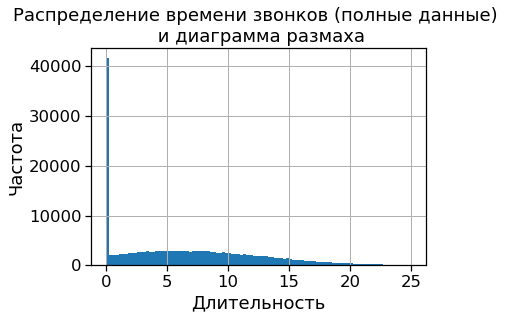

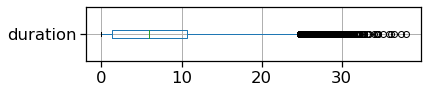

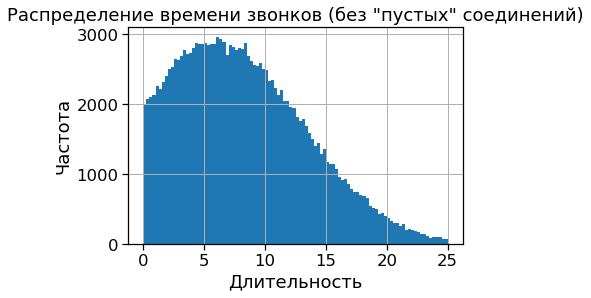

In [5]:
# Смотрим на данные
display(сalls_raw.info())
display(сalls_raw.head(3))
display(сalls_raw['duration'].value_counts())
display(missing_data(сalls_raw))
print('Дубликаты:', сalls_raw.duplicated().sum())

display(сalls_raw['duration'].hist(bins=100, range=(0, 25)))
plt.title('Распределение времени звонков (полные данные) \n и диаграмма размаха')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()
plt.figure(figsize=(6, 1))
сalls_raw.boxplot('duration', vert=False)
plt.show()

# Проверим в исследовании 2 варианта: полные данные и данные с отброшенными звонками нулевой длительности
сalls = сalls_raw.query('duration > 0').copy()
# сalls = сalls_raw

display(сalls['duration'].hist(bins=100, range=(0, 25)))
plt.title('Распределение времени звонков (без "пустых" соединений)')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

# Фильтруем данные
сalls = сalls.query('duration < 25').copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

,Total missing data,Percent missing data
user_id,0,0.0
session_date,0,0.0
mb_used,0,0.0
id,0,0.0
Unnamed: 0,0,0.0


Дубликаты: 0


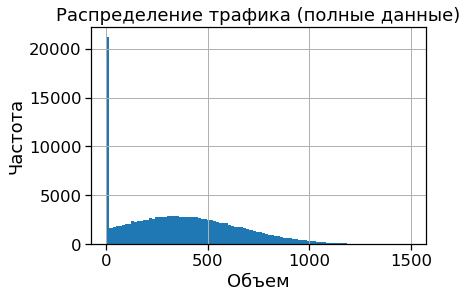

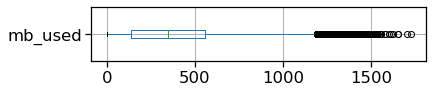

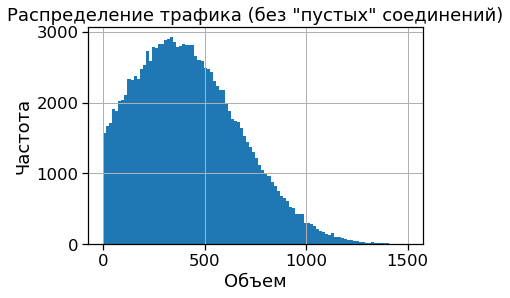

In [6]:
# Смотрим на данные
display(inet_raw.info())
display(inet_raw.head(3))
display(inet_raw['mb_used'].value_counts())
display(missing_data(inet_raw))
print('Дубликаты:', inet_raw.duplicated().sum())

display(inet_raw['mb_used'].hist(bins=100, range=(0, 1500)))
plt.title('Распределение трафика (полные данные)')
plt.xlabel('Объем')
plt.ylabel('Частота')
plt.figure(figsize=(6, 1))
inet_raw.boxplot('mb_used', vert=False)
plt.show()

# Проверим в исследовании  2 варианта: полные данные и данные с отброшенными соединениями нулевой длительности
inet = inet_raw.query('mb_used > 0').copy()
# inet = inet_raw

display(inet['mb_used'].hist(bins=100, range=(0, 1500)))
plt.title('Распределение трафика (без "пустых" соединений)')
plt.xlabel('Объем')
plt.ylabel('Частота')
plt.show()

# Фильтруем данные
inet = inet.query('mb_used < 1250').copy()

In [7]:
# Смотрим на данные
display(mes.info())
display(mes.head(3))
display(mes['message_date'].value_counts().sort_values())
print('Дубликаты:', mes.duplicated().sum())
display(missing_data(mes))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


2018-01-03      4
2018-01-02     10
2018-01-05     10
2018-01-04     10
2018-01-11     12
             ... 
2018-12-26    699
2018-12-29    702
2018-12-21    712
2018-12-30    765
2018-12-31    859
Name: message_date, Length: 364, dtype: int64

Дубликаты: 0


,Total missing data,Percent missing data
user_id,0,0.0
message_date,0,0.0
id,0,0.0


In [8]:
tar.info()
tar.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
display(users.info())
display(users.head(3))
print('Дубликаты:', users.duplicated().sum())
display(users['tariff'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


Дубликаты: 0


smart    351
ultra    149
Name: tariff, dtype: int64

#### Результаты предварительного анализа данных
---
- Пропущенные данные обнаружены в столбце `churn_date`.
- Аномальные значения отсутствуют. Имеются выбросы в длительности звонков и объеме трафика, их отфильтровали.
- Имеется большое количество звонков и интернет-сессий с нулевыми значениями
- Типы данных в интересующих нас столбцах соответствуют содержимому, кроме столбцов с датами. Их преобразуем при добавлении сведений о месяце совершенных действий.

#### Преобразуем интересующие нас данные

In [10]:
# Устанавливаем user_id в качестве индекса
users.set_index('user_id', inplace=True)

# Удаляем столбец "Unnamed: 0", он дублирует index
inet.drop(['Unnamed: 0'], axis='columns', inplace=True)

# Добавляем месяц совершенного действия, предварительно изменив тип данных
сalls['call_month'] = pd.to_datetime(сalls['call_date'], format='%Y-%m-%d').dt.month
# display(сalls)

mes['mes_month'] = pd.to_datetime(mes['message_date'], format='%Y-%m-%d').dt.month
# display(mes)

inet['inet_month'] = pd.to_datetime(inet['session_date'], format='%Y-%m-%d').dt.month
# display(inet)

#### Формируем сводную таблицу и добавляем необходимые данные

In [11]:
# Группируем по пользователю и месяцу
calls_gr = сalls.groupby(['user_id', 'call_month']).agg({'duration':['sum', 'count']}).reset_index()
# display(calls_gr)

mes_gr = mes.groupby(['user_id', 'mes_month']).agg({'message_date':['count']}).reset_index()
# display(mes_gr)

inet_gr = inet.groupby(['user_id', 'inet_month']).agg({'mb_used':['count', 'sum']}).reset_index()
# display(inet_gr)

# Объединяем все в сводную таблицу
cmi_gr_cm = (calls_gr
    .merge(mes_gr, how='outer', left_on=['user_id','call_month'], right_on=['user_id','mes_month'])
)
# Добавляем столбец с объединенными месяцами
cmi_gr_cm['call_mes_month'] = cmi_gr_cm['call_month'].combine_first(cmi_gr_cm['mes_month'])
# display(missing_data(cmi_gr_cm))

# Добавляем данные по интернету
cmi_gr = (cmi_gr_cm
    .merge(inet_gr, how='outer', left_on=['user_id','call_mes_month'], right_on=['user_id','inet_month'])
)
# display(cmi_gr)

# Меняем тип переменнных после объединения
cmi_gr[[('call_month',''), ('mes_month',''), ('inet_month','')]] = (
    cmi_gr[[('call_month',''), ('mes_month',''), ('inet_month','')]].astype('Int64')
)
# display(cmi_gr)

# Добавляем тариф в сводную таблицу
def add_tariff(row):
    return users.loc[row[('user_id', '')], 'tariff']
    
cmi_gr[('tariff', 'name')] = cmi_gr.apply(add_tariff, axis=1)
# display(cmi_gr)

# Добавляем признак Москвы в сводную таблицу
def add_Moscow(row):
    return users.loc[row[('user_id', '')], 'city'] == 'Москва'
    
cmi_gr[('is_moscow', '')] = cmi_gr.apply(add_Moscow, axis=1)
# display(cmi_gr)

# добавим уровень в индекс для объединения
tar_mod = tar.reset_index()
tar_mod.columns = pd.MultiIndex.from_product([tar_mod.columns, ['']])
# display(tar_mod)

# Добавляем в сводную таблицу параметры тарифов
cmi_gr_tar = cmi_gr.merge(tar_mod, left_on=[('tariff', 'name')], right_on=[('tariff_name', '')], how='left')
# display(cmi_gr_tar)

# Считаем затраты на интернет сверх тарифа
cmi_gr_tar[('higher_tariff', 'inet')] = (
    np.floor((np.ceil(cmi_gr_tar[('mb_used', 'sum')])-cmi_gr_tar[('mb_per_month_included', '')]).clip(0, None)/1024)
    *cmi_gr_tar[('rub_per_gb', '')]
)

# Считаем затраты на сообщения сверх тарифа
cmi_gr_tar[('higher_tariff', 'messages')] = (
    (cmi_gr_tar[('message_date', 'count')]-cmi_gr_tar[('messages_included', '')]).clip(0, None)
    *cmi_gr_tar[('rub_per_message', '')]
)

# Считаем затраты на звонки сверх тарифа
cmi_gr_tar[('higher_tariff', 'call')] = (
    (np.ceil(cmi_gr_tar[('duration', 'sum')])-cmi_gr_tar[('minutes_included', '')]).clip(0, None)
    *cmi_gr_tar[('rub_per_minute', '')]
)

# Заполняем пропущенные значения нулями
cmi_gr_tar[('higher_tariff','inet')].fillna(0, inplace=True)
cmi_gr_tar[('higher_tariff','messages')].fillna(0, inplace=True)
cmi_gr_tar[('higher_tariff','call')].fillna(0, inplace=True)
# ??? Передача списком почему-то не работает ???
# cmi_gr_tar[[('higher_tariff','inet'), ('higher_tariff','messages'), ('higher_tariff','call')]].fillna(0, inplace=True)

# Считаем выручку
cmi_gr_tar['revenue'] = (
    cmi_gr_tar[('higher_tariff','inet')]
    +cmi_gr_tar[('higher_tariff','messages')]
    +cmi_gr_tar[('higher_tariff','call')]
    +cmi_gr_tar[('rub_monthly_fee')]
)
display(cmi_gr_tar)

C:\Users\iserg\anaconda3\envs\First\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


user_id call_month duration       mes_month message_date call_mes_month  \
                             sum count                  count                  
0       1000          5   150.06  17.0         5         22.0            5.0   
1       1000          6   158.90  28.0         6         60.0            6.0   
2       1000          7   318.80  41.0         7         75.0            7.0   
3       1000          8   389.87  42.0         8         81.0            8.0   
4       1000          9   440.14  46.0         9         57.0            9.0   
...      ...        ...      ...   ...       ...          ...            ...   
3209    1489       <NA>      NaN   NaN        10         21.0           10.0   
3210    1489       <NA>      NaN   NaN        11         20.0           11.0   
3211    1489       <NA>      NaN   NaN        12         35.0           12.0   
3212    1240       <NA>      NaN   NaN      <NA>          NaN            NaN   
3213    1476       <NA>      NaN   NaN      <NA>          NaN            NaN   

     inet_month mb_used            ... minutes_included rub_monthly_fee  \
                  count       sum  ...                                    
0             5     4.0   2253.49  ...             3000            1950   
1             6    44.0  23233.77  ...             3000            1950   
2             7    28.0  14003.64  ...             3000            1950   
3             8    27.0  14055.93  ...             3000            1950   
4             9    25.0  14568.91  ...             3000            1950   
...         ...     ...       ...  ...              ...             ...   
3209         10    52.0  19559.44  ...              500             550   
3210         11    45.0  17491.56  ...              500             550   
3211         12    43.0  17322.51  ...              500             550   
3212          2     3.0    959.51  ...             3000            1950   
3213          4     1.0    530.78  ...             3000            1950   

     rub_per_gb rub_per_message rub_per_minute tariff_name higher_tariff  \
                                                                    inet   
0           150               1              1       ultra           0.0   
1           150               1              1       ultra           0.0   
2           150               1              1       ultra           0.0   
3           150               1              1       ultra           0.0   
4           150               1              1       ultra           0.0   
...         ...             ...            ...         ...           ...   
3209        200               3              3       smart         800.0   
3210        200               3              3       smart         400.0   
3211        200               3              3       smart         200.0   
3212        150               1              1       ultra           0.0   
3213        150               1              1       ultra           0.0   

                   revenue  
     messages call          
0         0.0  0.0  1950.0  
1         0.0  0.0  1950.0  
2         0.0  0.0  1950.0  
3         0.0  0.0  1950.0  
4         0.0  0.0  1950.0  
...       ...  ...     ...  
3209      0.0  0.0  1350.0  
3210      0.0  0.0   950.0  
3211      0.0  0.0   750.0  
3212      0.0  0.0  1950.0  
3213      0.0  0.0  1950.0  

[3214 rows x 25 columns]

#### Делим на тарифы Смарт и Ультра

In [12]:
# Разделение на тарифы Смарт и Ультра
all_smart = cmi_gr_tar[cmi_gr_tar[('tariff_name','')] == 'smart']
# display('smart:', all_smart)
all_ultra = cmi_gr_tar[cmi_gr_tar[('tariff_name','')] == 'ultra']
# display('ultra:', all_ultra)

In [13]:
# Функция для преобразования датафрейма в серию
def df_to_series(df):
    L=[]
    for m in df.values.tolist():
        L += m
    return pd.Series(L)

# Функция вывода статистики
def print_stat(ser):
    print('Среднее:', ser.mean().round(1))
    print('Медиана:', ser.median().round(1))
    print('Дисперсия:', np.var(ser, ddof=1).round(1))
    print('Стандартное отклонение:', np.std(ser, ddof=1).round(1), '\n')

### Длительность звонков

Статистика по тарифу "Смарт":
Среднее: 390.6
Медиана: 391.6
Дисперсия: 31069.2
Стандартное отклонение: 176.3 

Статистика по тарифу "Ультра":
Среднее: 509.8
Медиана: 489.9
Дисперсия: 81088.4
Стандартное отклонение: 284.8 



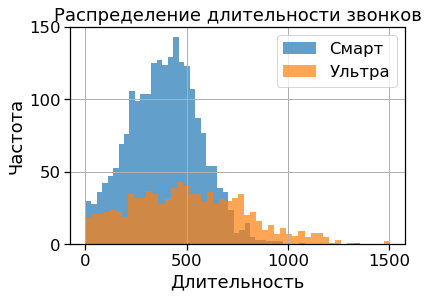

In [14]:
# Сводная таблица длительности звонков
smart_call_pt_bymonth = all_smart.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('duration','sum'):['sum']})
# display(smart_call_pt_bymonth)

ultra_call_pt_bymonth = all_ultra.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('duration','sum'):['sum']})
# display(ultra_call_pt_bymonth)
    
calls_smart = df_to_series(smart_call_pt_bymonth)
print('Статистика по тарифу "Смарт":')
print_stat(calls_smart)

calls_ultra = df_to_series(ultra_call_pt_bymonth)
print('Статистика по тарифу "Ультра":')
print_stat(calls_ultra)

display(calls_smart.hist(bins=50, alpha=0.7, label='Смарт'))
display(calls_ultra.hist(bins=50, alpha=0.7, label='Ультра'))
plt.title('Распределение длительности звонков')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.legend()

#### Вывод
---
Тариф "Смарт":
- пользователи разговаривают в среднем 390.6 минут в месяц
- стандартное отклонение по выборке 176.3 
- дисперсия по выборке 31069.2
- гистограмма близка к нормальному распределению, имеет скошенность влево
---
Тариф "Ультра":
- пользователи разговаривают в среднем 509.8 минут в месяц
- стандартное отклонение по выборке 284.8
- дисперсия по выборке 81088.4
- гистограмма близка к нормальному распределению, имеет скошенность вправо
---
В среднем пользователи тарифа "Ультра" разговаривают больше в 1.3 раза.

Наличие в исследуемых данных звонков с нулевой длительностью практически не оказывает влияния на результат.

### Количество сообщений

Статистика по тарифу "Смарт":
Среднее: 33.4
Медиана: 28.0
Дисперсия: 799.2
Стандартное отклонение: 28.3 

Статистика по тарифу "Ультра":
Среднее: 48.8
Медиана: 39.0
Дисперсия: 2171.7
Стандартное отклонение: 46.6 



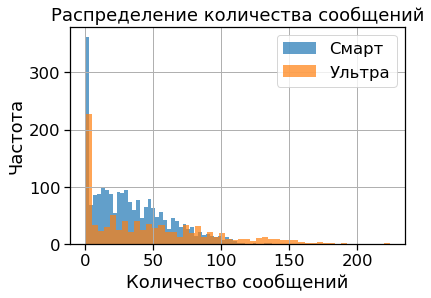

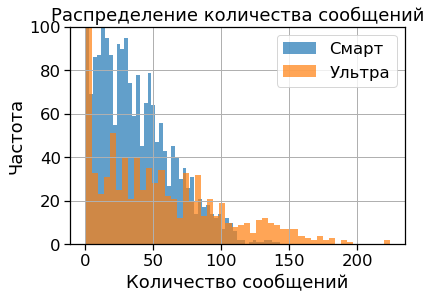

In [15]:
# Сводная таблица количества сообщений
smart_mes_pt_bymonth = all_smart.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('message_date','count'):['sum']})
# display(smart_mes_pt_bymonth)

ultra_mes_pt_bymonth = all_ultra.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('message_date','count'):['sum']})
# display(ultra_mes_pt_bymonth)
    
mes_smart = df_to_series(smart_mes_pt_bymonth)
print('Статистика по тарифу "Смарт":')
print_stat(mes_smart)
# print(mes_smart.value_counts())

mes_ultra = df_to_series(ultra_mes_pt_bymonth)
print('Статистика по тарифу "Ультра":')
print_stat(mes_ultra)
# print(mes_ultra.value_counts())

display(mes_smart.hist(bins=50, alpha=0.7, label='Смарт'))
display(mes_ultra.hist(bins=50, alpha=0.7, label='Ультра'))
plt.title('Распределение количества сообщений')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота')
plt.legend()
plt.show()

display(mes_smart.hist(bins=50, alpha=0.7, label='Смарт'))
display(mes_ultra.hist(bins=50, alpha=0.7, label='Ультра'))
plt.ylim(0, 100)
plt.title('Распределение количества сообщений')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота')
plt.legend()

#### Вывод
---
Тариф "Смарт":
- пользователи отправляют в среднем 33.4 сообщения в месяц
- стандартное отклонение по выборке 28.3
- дисперсия по выборке 799.2
- без учета нулевых значений гистограмма похожа на нормальное распределение, имеет скошенность вправо
---
Тариф "Ультра":
- пользователи отправляют в среднем 48.8 сообщения в месяц
- стандартное отклонение по выборке 46.6
- дисперсия по выборке 2171.7
- без учета нулевых значений гистограмма похожа на нормальное распределение, имеет скошенность вправо
---
Имеются пользователи, которые не отправляют сообщения.

В среднем пользователи тарифа "Ультра" отправляют больше сообщений в 1.45 раза.

### Объём интернет-трафика

Статистика по тарифу "Смарт":
Среднее: 16169.1
Медиана: 16456.4
Дисперсия: 34337907.2
Стандартное отклонение: 5859.9 

Статистика по тарифу "Ультра":
Среднее: 19156.3
Медиана: 18982.2
Дисперсия: 99086990.5
Стандартное отклонение: 9954.2 



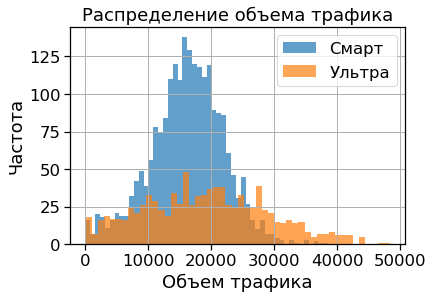

In [16]:
# Сводная таблица объема трафика
smart_inet_pt_bymonth = all_smart.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('mb_used','sum'):['sum']})
# display(smart_inet_pt_bymonth)

ultra_inet_pt_bymonth = all_ultra.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('mb_used','sum'):['sum']})
# display(ultra_inet_pt_bymonth)
    
inet_smart = df_to_series(smart_inet_pt_bymonth)
print('Статистика по тарифу "Смарт":')
print_stat(inet_smart)

inet_ultra = df_to_series(ultra_inet_pt_bymonth)
print('Статистика по тарифу "Ультра":')
print_stat(inet_ultra)

display(inet_smart.hist(bins=50, alpha=0.7, label='Смарт'))
display(inet_ultra.hist(bins=50, alpha=0.7, label='Ультра'))
plt.title('Распределение объема трафика')
plt.xlabel('Объем трафика')
plt.ylabel('Частота')
plt.legend()
plt.show()

#### Вывод
---
Тариф "Смарт":
- пользователи потребляют в среднем 16169.1 Мб в месяц
- стандартное отклонение по выборке 5859.9 
- дисперсия по выборке 34337907.2
- гистограмма близка к нормальному распределению, имеет небольшую скошенность влево
---
Тариф "Ультра":
- пользователи потребляют в среднем 19156.3 Мб в месяц
- стандартное отклонение по выборке 10127.9
- дисперсия по выборке 102574058.8
- гистограмма близка к нормальному распределению, имеет небольшую скошенность вправо
---
В среднем пользователи тарифа "Ультра" потребляют больше интернет-трафика в 1.2 раза.

Наличие в исследуемых данных соединений с нулевым объемом интернет-трафика не оказывает влияния на результат.

### Выручка  тарифов «Ультра» и «Смарт»
---
Нулевая гипотеза H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова

Альтернативная гипотеза H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» отличается

Пороговое значение alpha зададим на уровне 1%, чтобы снизить вероятность случайного отвержения нулевой гипотезы (не более 1%).

Статистика по тарифу "Смарт":
Среднее: 1129.1
Медиана: 802.0
Дисперсия: 536631.4
Стандартное отклонение: 732.6 

Статистика по тарифу "Ультра":
Среднее: 2039.7
Медиана: 1950.0
Дисперсия: 97461.5
Стандартное отклонение: 312.2 



p-значение: 0.0
Отвергаем нулевую гипотезу


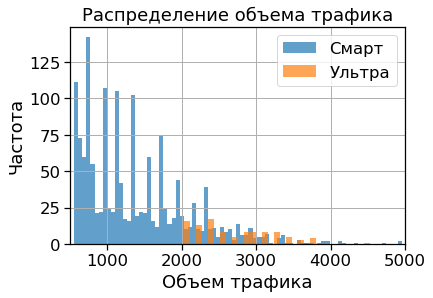

In [17]:
# Сводная таблица месячной выручки
smart_rev_pt_bymonth = all_smart.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('revenue',''):['sum']})
# display(smart_rev_pt_bymonth)

ultra_rev_pt_bymonth = all_ultra.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('revenue',''):['sum']})
# display(ultra_rev_pt_bymonth)

rev_smart = df_to_series(smart_rev_pt_bymonth)
print('Статистика по тарифу "Смарт":')
print_stat(rev_smart)
    
rev_ultra = df_to_series(ultra_rev_pt_bymonth)
print('Статистика по тарифу "Ультра":')
print_stat(rev_ultra)

display(rev_smart.hist(bins=100, range=(555, 6000), alpha=0.7, label='Смарт'))
display(rev_ultra.hist(bins=100, range=(1955, 10000), alpha=0.7, label='Ультра'))
plt.title('Распределение объема трафика')
plt.xlabel('Объем трафика')
plt.ylabel('Частота')
plt.xlim(500, 5000)
plt.legend()


# Проверим гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = .01 # критический уровень статистической значимости
results = st.ttest_ind(rev_smart.dropna().values, rev_ultra.dropna().values, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

#### Вывод
Нулевая гипотеза отвергнута. Средняя выручка тарифов «Ультра» и «Смарт» статистически значимо различается. p-значение очень мало, вероятность ошибочного отклонения нулевой гипотезы крайне мала.
В среднем выручка по тарифу "Ультра" в 1,8 раза больше.

In [18]:
# Разделение на Москву и регионы
all_Moscow = cmi_gr_tar[cmi_gr_tar[('is_moscow', '')]]
# display('Moscow:', all_Moscow)
all_regions = cmi_gr_tar[~cmi_gr_tar[('is_moscow', '')]]
# display('regoins:', all_regions)

### Выручка  в Москве и регионах
---
Нулевая гипотеза H0: средняя выручка пользователей в Москве и регионах одинакова

Альтернативная гипотеза H1: средняя выручка пользователей в Москве и регионах отличается

Пороговое значение alpha зададим стандартным 5%.

Статистика по регионам:
Среднее: 1394.1
Медиана: 1350.0
Дисперсия: 592789.1
Стандартное отклонение: 769.9 

Статистика по Москве:
Среднее: 1431.6
Медиана: 1550.0
Дисперсия: 521297.1
Стандартное отклонение: 722.0 



C:\Users\iserg\anaconda3\envs\First\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\iserg\anaconda3\envs\First\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


p-значение: 0.2551447200221328
Не получилось отвергнуть нулевую гипотезу


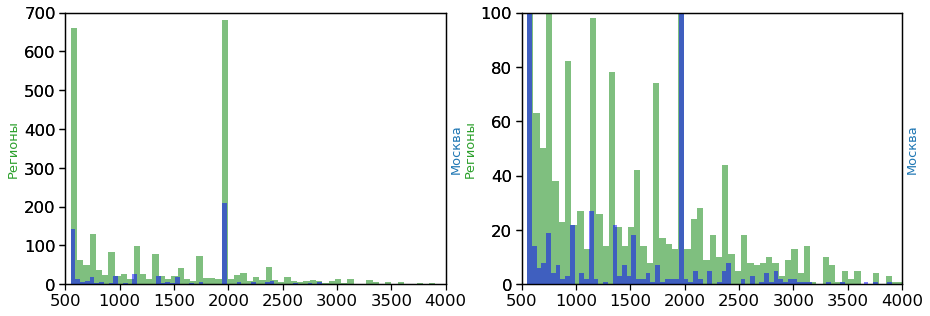

In [19]:
# Сводная таблица месячной выручки
regions_pt_bymonth = all_regions.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('revenue',''):['sum']})
# display(regions_pt_bymonth)

moscow_pt_bymonth = all_Moscow.pivot_table(index=[('call_month','')], columns=[('user_id','')], aggfunc={('revenue',''):['sum']})
# display(moscow_pt_bymonth)
    
rev_regions = df_to_series(regions_pt_bymonth)
print('Статистика по регионам:')
print_stat(rev_regions)
    
rev_moscow = df_to_series(moscow_pt_bymonth)
print('Статистика по Москве:')
print_stat(rev_moscow)

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(rev_regions, bins=100, alpha=0.5, color='g')
ax1.yaxis.set_ticks_position("right")
ax1.set_ylabel('Регионы', color='tab:green', fontsize=13)
plt.xlim(500, 4000)
plt.ylim(0, 700)

ax2 = ax1.twinx()
ax2.hist(rev_moscow, bins=100, alpha=0.5, color='b')
ax2.yaxis.set_ticks_position("left")
ax2.set_ylabel('Москва', color='tab:blue', fontsize=13)
plt.xlim(500, 4000)
plt.ylim(0, 700)

ax1 = plt.subplot(1, 2, 2)
ax1.hist(rev_regions, bins=100, alpha=0.5, color='g')
ax1.yaxis.set_ticks_position("right")
ax1.set_ylabel('Регионы', color='tab:green', fontsize=13)
plt.xlim(500, 4000)
plt.ylim(0, 100)

ax2 = ax1.twinx()
ax2.hist(rev_moscow, bins=100, alpha=0.5, color='b')
ax2.yaxis.set_ticks_position("left")
ax2.set_ylabel('Москва', color='tab:blue', fontsize=13)
plt.xlim(500, 4000)
plt.ylim(0, 100)

# Проверим гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = .05 # критический уровень статистической значимости
results = st.ttest_ind(rev_moscow.dropna().values, rev_regions.dropna().values, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

#### Вывод
Нулевая гипотеза подтверждена. Средняя выручка в Москве и регионах одинакова, статистически значимого различия нет.
Средняя выручка в Москве 1431.6 руб., в регионах - 1394.1 руб.

## Общие выводы
---
### Проанализировано время разговора клиентов тарифов "Смарт" и "Ультра", количество сообщений и объём интернет-трафика в месяц.

---
#### Длительность звонков
- Пользователи тарифа "Смарт" разговаривают в среднем 390.6 минут в месяц
- Пользователи тарифа "Ультра" разговаривают в среднем 509.8 минут в месяц, что в 1.3 раза больше тарифа "Смарт".

---
#### Количество сообщений
- Пользователи тарифа "Смарт" отправляют в среднем 33.4 сообщения в месяц
- Пользователи тарифа "Ультра" отправляют в среднем 48.8 сообщения в месяц, что в 1.45 раза больше тарифа "Смарт".

---
#### Объём интернет-трафика
- Пользователи тарифа "Смарт" потребляют в среднем 16169.1 Мб в месяц
- Пользователи тарифа "Ультра" потребляют в среднем 19156.3 Мб в месяц, что в в 1.2 раза больше тарифа "Смарт".

### Проверены 2 гипотезы
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Результат проверки гипотез
1. Гипотеза подтверждена, выручка пользователей тарифов «Ультра» 2039.7 руб./мес и «Смарт» 1129.1 руб./мес статистически значимо различается. Тариф "Ультра" дает выручку примерно в 1.8 раза больше, чем тариф "Смарт".
2. Гипотеза не подтверждена. Выручка в Москве и регионах практически одинакова, статистически значимого различия нет.